In [1]:
import sys, os, time, datetime, h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from scipy.stats import norm, expon, chi2, uniform, chisquare

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.constraints import Constraint
from tensorflow.keras import metrics, losses, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Layer

2023-04-02 12:53:26.221180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorfl

In [2]:
def compute_df(input_size, hidden_layers, output_size=1):
    """                                                                                                                           
    Compute degrees of freedom of a neural net (number of trainable params)                                                       
                                                                                                                                  
    input_size :    (int) size of the input layer                                                                                 
    hidden_layers : (list) list specifiying size of hidden layers                                                                 
    latentsize :    (int) number of hidden units for each layer                                                                   
                                                                                                                                  
    df : (int) degrees of freedom                                                                                                 
    """
    nn_arch = [input_size] + hidden_layers + [output_size]
    df = sum(map(lambda x, y : x*(y+1), nn_arch[1:], nn_arch[:-1]))
    return df

# set up parameters

In [3]:
#### statistics                                                                                 \                                                                                                 
N_ref      = 200000
N_Bkg      = 2000
N_Sig      = 10
z_ratio    = N_Bkg*1./N_ref
Sig_loc    = 1.6
Sig_std    = 0.16
extra_flat_dimensions = 0

#### training time                                                                               
total_epochs   = 30000 # for this application of NPLM 300000 epochs should be run to complete the training

#### architecture                                                                                
BSMweight_clipping = None
BSMbias_clipping   = None
BSMarchitecture    = [1,4,1]
BSM_l1             = None
BSM_l2             = None
BSM_use_bias       = None
inputsize          = BSMarchitecture[0]
BSMdf              = compute_df(input_size=BSMarchitecture[0], hidden_layers=BSMarchitecture[1:-1])


# DATA

In [4]:
# data                                                                                                                            
N_Bkg_Pois  = np.random.poisson(lam=N_Bkg, size=1)[0]
N_ref_Pois  = np.random.poisson(lam=N_ref, size=1)[0]
N_observed_ref = N_ref_Pois
if N_Sig:
    N_Sig_Pois = np.random.poisson(lam=N_Sig, size=1)[0]

featureData = np.random.exponential(scale=1, size=(N_Bkg_Pois, 1))
if N_Sig:
    featureSig  = np.random.normal(loc=Sig_loc, scale=Sig_std, size=(N_Sig_Pois,1))
    featureData = np.concatenate((featureData, featureSig), axis=0)
featureRef  = np.random.exponential(scale=1, size=(N_ref_Pois, 1))
feature     = np.concatenate((featureData, featureRef), axis=0)

for i in range(extra_flat_dimensions):
    flat = np.random.uniform(size=(feature.shape[0],1))
    feature = np.concatenate((feature, flat), axis=1)

# target                                                                                                                         \
                                                                                                                                  
targetData  = np.ones_like(featureData)
targetRef   = np.zeros_like(featureRef)
weightsData = np.ones_like(featureData)
weightsRef  = np.ones_like(featureRef)*z_ratio
target      = np.concatenate((targetData, targetRef), axis=0)
weights     = np.concatenate((weightsData, weightsRef), axis=0)
target      = np.concatenate((target, weights), axis=1)

/tmp/ipykernel_1181/3293305107.py:42: RuntimeWarning: invalid value encountered in true_divide
  plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')


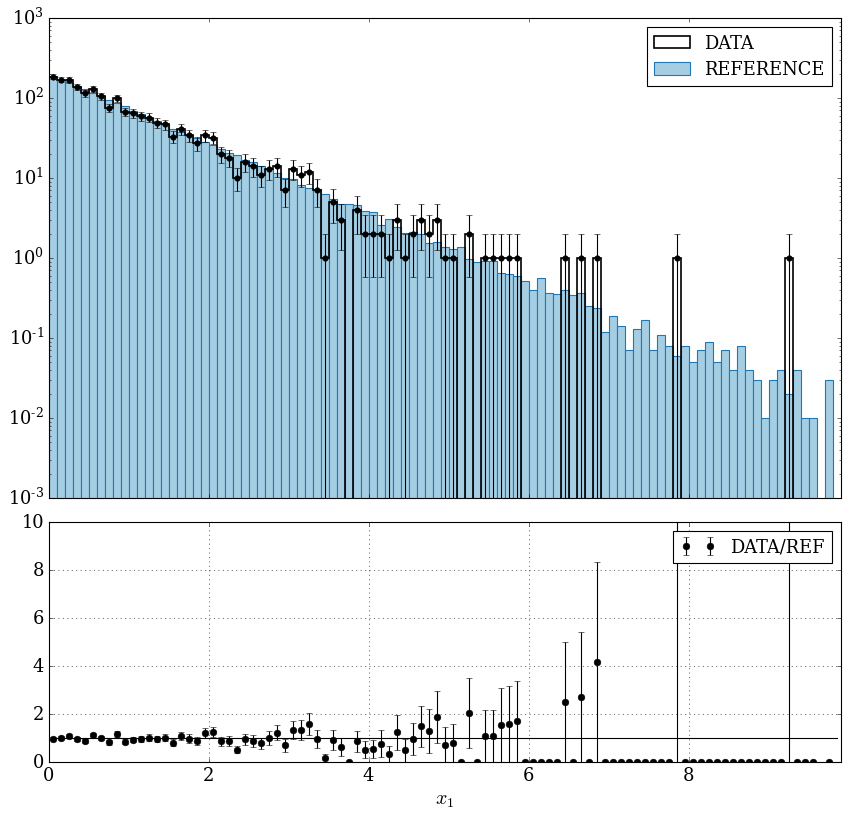

In [5]:
REF    = feature[target[:, 0]==0]
DATA   = feature[target[:, 0]==1]
weight = target[:, 1]
weight_REF       = weight[target[:, 0]==0]
weight_DATA      = weight[target[:, 0]==1]
bins_code = {
    'x1': np.arange(0, 10, 0.1),
}
xlabel_code = {
    'x1': r'$x_1$',
}
ymax_code = {                                                                                                                                                                                                                                                                       
    'x1': 10                                                                                                                             
}  
for i in range(extra_flat_dimensions):
    bins_code['x%i'%(i+1)] = np.arange(0, 1, 0.01)
    xlabel_code['x%i'%(i+1)] = 'x%i'%(i+1)
feature_labels = list(bins_code.keys())

plt_i = 0
for key in feature_labels:
    bins = bins_code[key]
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig = plt.figure(figsize=(10, 10))                                                                                                                                            
    fig.patch.set_facecolor('white')                                                                                                                                              
    ax1 = fig.add_axes([0., 0.33, 0.99, 0.6])        
    hD = plt.hist(DATA[:, plt_i],weights=weight_DATA, 
                  bins=bins, label='DATA', color='black', lw=1.5, histtype='step', zorder=4)
    hR = plt.hist(REF[:, plt_i], weights=weight_REF, color='#a6cee3',     
                  ec='#1f78b4', bins=bins, lw=1, label='REFERENCE')
    plt.errorbar(0.5*(bins[1:]+bins[:-1]), hD[0],  yerr= np.sqrt(hD[0]), color='black', ls='', marker='o', ms=5, zorder=3)
    font = font_manager.FontProperties(family='serif', size=16)
    l    = plt.legend(fontsize=18, prop=font)
    font = font_manager.FontProperties(family='serif', size=18) 
    plt.tick_params(axis='x', which='both',    labelbottom=False)
    plt.yticks(fontsize=16, fontname='serif')
    plt.xlim(bins[0], bins[-1])
    plt.yscale('log')
    ax2 = fig.add_axes([0., 0., 0.99, 0.3]) 
    x = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')
    plt.plot(x, np.ones_like(x), lw=1, color='black')
    font = font_manager.FontProperties(family='serif', size=16)
    plt.legend(fontsize=18, prop=font)
    plt.xlabel(xlabel_code[key], fontsize=18, fontname='serif')
    plt.ylim(0., ymax_code[key])
    plt.yticks(fontsize=16, fontname='serif')
    plt.xticks(fontsize=16, fontname='serif')
    plt.xlim(bins[0], bins[-1])
    
    plt.grid() 
    plt.show()
    plt_i+=1

# NN Model

In [6]:
class BSMfinderNet(Model):
    def __init__(self, input_shape, architecture=[1, 4, 1], weight_clipping=None, bias_clipping=None,
                 activation='sigmoid', activation_out='linear', trainable=True,
                 l1=None, l2=None, use_bias=True, kernel_initializer=None, bias_initializer=None, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        kernel_initializer = "glorot_uniform"
        bias_initializer   = "zeros"
        kernel_regularizer = None
        bias_regularizer   = None
        kernel_constraint  = [None for i in range(len(architecture)-1)]
        bias_constraint    = [None for i in range(len(architecture)-1)]
        if not kernel_initializer==None:
            kernel_initializer = kernel_initializer
        if not bias_initializer==None:
            bias_initializer   = bias_initializer

        if not l1==None:
            kernel_regularizer = tf.keras.regularizers.L1(l1=l1, **kwargs)
            bias_regularizer = tf.keras.regularizers.L1(l1=l1, **kwargs)

        if not l2==None:
            kernel_regularizer = tf.keras.regularizers.L2(l2=l2, **kwargs)
            bias_regularizer = tf.keras.regularizers.L2(l2=l2, **kwargs)

        if not weight_clipping == None:
            if not isinstance(weight_clipping, list):
                wc = [weight_clipping for i in range(len(architecture)-1)]
            else:
                wc = weight_clipping
            kernel_constraint = [EterogeneousWeightClip(input_dim=architecture[i], output_dim=architecture[i+1],
                                                        clip=wc[i]) for i in range(len(architecture)-1)]
        if not bias_clipping == None and use_bias == True:
            if not isinstance(bias_clipping, list):
                bc = [bias_clipping for i in range(len(architecture)-1)]
            else:
                bc = bias_clipping
            bias_constraint = [EterogeneousBiasClip(input_dim=architecture[i], output_dim=architecture[i+1],
                                                        clip=bc[i]) for i in range(len(architecture)-1)]
        self.hidden_layers = [Dense(architecture[i+1], input_shape=(architecture[i],),
                                    use_bias=use_bias,
                                    activation=activation, trainable=trainable,
                                    kernel_constraint  = kernel_constraint[i],
                                    bias_constraint    = bias_constraint[i],
                                    kernel_regularizer = kernel_regularizer,
                                    bias_regularizer   = bias_regularizer,
                                    kernel_initializer = kernel_initializer,
                                    bias_initializer=bias_initializer) for i in range(len(architecture)-2)]
        self.output_layer  = Dense(architecture[-1], input_shape=(architecture[-2],),
                                   activation=activation_out, trainable=trainable,
                                   use_bias=use_bias,
                                   kernel_constraint  = kernel_constraint[-1],
                                   bias_constraint    = bias_constraint[-1],
                                   kernel_regularizer = kernel_regularizer,
                                   bias_regularizer   = bias_regularizer,
                                   kernel_initializer = kernel_initializer,
                                   bias_initializer=bias_initializer)
        self.build(input_shape)

    def call(self, x):
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = hidden_layer(x)
        x = self.output_layer(x)
        return x
    
def NPLM_loss(true, pred):
    f   = pred[:, 0]
    y   = true[:, 0]
    w   = true[:, 1]
    return tf.reduce_sum((1-y)*w*(tf.exp(f)-1) - y*w*(f))


class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range                                                                                                
    '''
    def __init__(self, c=2):
        self.c = c
    def __call__(self, p):
        return tf.clip_by_value(p, clip_value_min=-self.c, clip_value_max=self.c)
    def get_config(self):
        return {'name': self.__class__.__name__,
                'c': self.c}

In [7]:
batch_size  = feature.shape[0]
inputsize   = feature.shape[1]

In [8]:
model = BSMfinderNet(input_shape=(None, inputsize), 
                     architecture=BSMarchitecture, 
                     weight_clipping=BSMweight_clipping, bias_clipping=BSMbias_clipping,
                     activation='sigmoid', activation_out='linear', trainable=True,
                     l1=BSM_l1, l2=BSM_l2, use_bias=BSM_use_bias, 
                     kernel_initializer=None, bias_initializer=None
                     )
print(model.summary())

2023-04-02 12:53:36.721933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

Model: "bs_mfinder_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  4         
                                                                 
 dense_1 (Dense)             multiple                  4         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
model.compile(loss=NPLM_loss,  optimizer='adam')

In [10]:
t0=time.time()
hist = model.fit(feature, target, batch_size=batch_size, epochs=total_epochs, verbose=False)
t1=time.time()
print('Training time: ',(t1-t0)/60.,' (minutes)')
print()


Training time:  10.228602119286855  (minutes)



In [11]:
# metrics                                                                                                                                                        
loss  = np.array(hist.history['loss'])

# test statistic                                                                                                                                                                                                                                                                                                               
final_loss = loss[-1]
t_OBS    = -2*final_loss
print('Tau: ', t_OBS)

Tau:  3.409651756286621


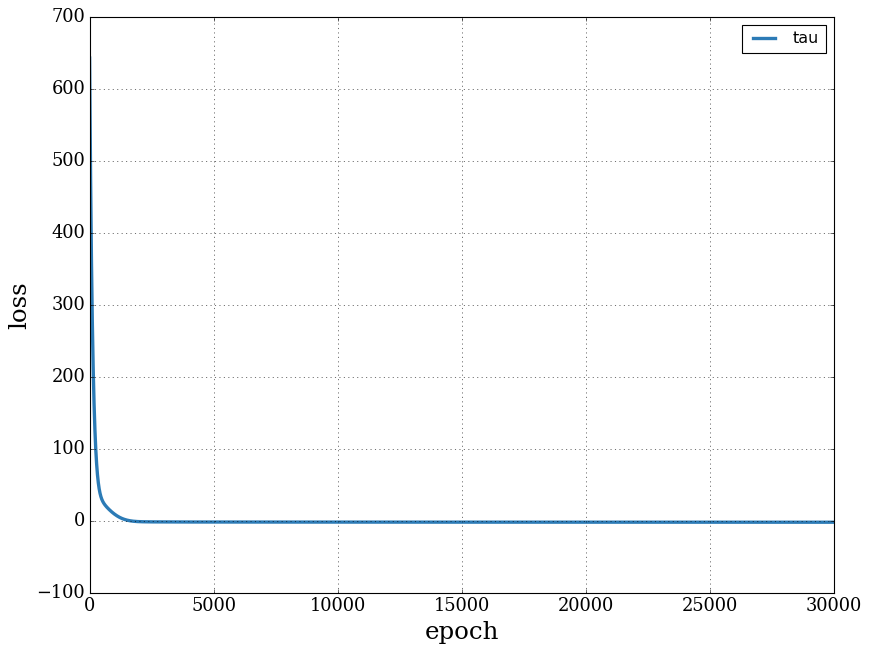

In [12]:
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')
fig  = plt.figure(figsize=(12, 9))
fig.patch.set_facecolor('white')
plt.plot(loss, label='tau',color='#2c7bb6',lw=3)
plt.legend()
plt.ylabel('loss', fontsize=22, fontname='serif')
plt.xlabel('epoch',   fontsize=22, fontname='serif')
plt.yticks(fontsize=16, fontname='serif')
plt.xticks(fontsize=16, fontname='serif')
#plt.yscale('log')
plt.grid()
plt.show()

# NN reconstruction

In [14]:
REF    = feature[target[:, 0]==0]
DATA   = feature[target[:, 0]==1]
weight = target[:, 1]

weight_REF       = weight[target[:, 0]==0]
weight_DATA      = weight[target[:, 0]==1]
output_tau_ref   = model.predict(REF)

/tmp/ipykernel_1181/435333125.py:29: RuntimeWarning: invalid value encountered in true_divide
  plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')
/tmp/ipykernel_1181/435333125.py:30: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, hN[0]/hR[0], label =r'$t$ RECO/REF', color='#b2df8a', lw=3)


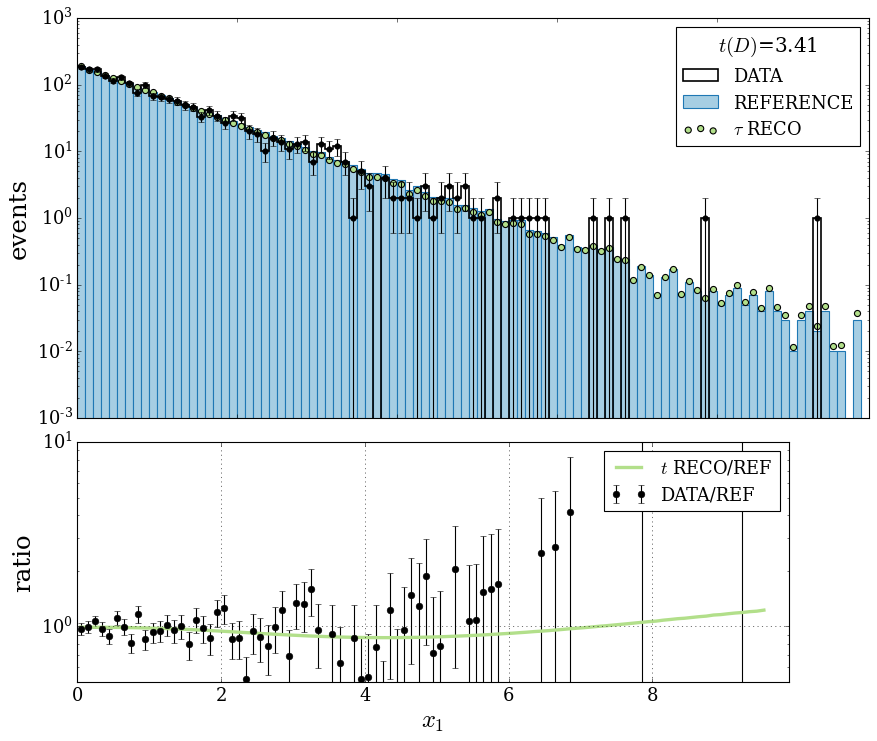

In [18]:
plt_i = 0
for key in feature_labels:
    bins = bins_code[key]
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig = plt.figure(figsize=(10, 10))                                                                                                                                            
    fig.patch.set_facecolor('white')                                                                                                                                              
    ax1 = fig.add_axes([0.1, 0.43, 0.99, 0.5])        
    hD = plt.hist(DATA[:, plt_i],weights=weight_DATA, 
                  bins=bins, label='DATA', color='black', lw=1.5, histtype='step', zorder=4)
    hR = plt.hist(REF[:, plt_i], weights=weight_REF, color='#a6cee3',     
                  ec='#1f78b4', bins=bins, lw=1, label='REFERENCE')
    hN = plt.hist(REF[:, plt_i], weights=np.exp(output_tau_ref[:, 0])*weight_REF, 
                  histtype='step', bins=bins, lw=0)
    plt.errorbar(0.5*(bins[1:]+bins[:-1]), hD[0],  yerr= np.sqrt(hD[0]), color='black', ls='', marker='o', ms=5, zorder=3)
    plt.scatter(0.5*(bins[1:]+bins[:-1]),  hN[0],  edgecolor='black', label=r'$\tau$ RECO',   color='#b2df8a', lw=1, s=30, zorder=2)
    font = font_manager.FontProperties(family='serif', size=16)
    l    = plt.legend(prop=font, ncol=1)
    font = font_manager.FontProperties(family='serif', size=18) 
    title =r'$t(D)$='+str(np.around(t_OBS, 2))
    l.set_title(title=title, prop=font)
    plt.tick_params(axis='x', which='both',    labelbottom=False)
    plt.yticks(fontsize=16, fontname='serif')
    plt.xlim(bins[0], bins[-1])
    plt.ylabel('events', fontsize=22, fontname='serif')
    plt.yscale('log')
    ax2 = fig.add_axes([0.1, 0.1, 0.89, 0.3]) 
    x = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')
    plt.plot(x, hN[0]/hR[0], label =r'$t$ RECO/REF', color='#b2df8a', lw=3)
    font = font_manager.FontProperties(family='serif', size=16)
    plt.legend(prop=font)
    plt.yticks(fontsize=16, fontname='serif')
    plt.xticks(fontsize=16, fontname='serif')
    plt.xlim(bins[0], bins[-1])
    plt.ylim(0.5, ymax_code[key])
    plt.yscale('log')
    plt.ylabel('ratio', fontsize=22, fontname='serif')
    plt.xlabel(xlabel_code[key], fontsize=22, fontname='serif')
    plt.grid()
    #plt.savefig(folder_output+filename+'_200k.pdf')
    plt.show()
    plt_i+=1